Can we capture the variability in both precip. and prob. of precip. with a single NN?

In [1]:
import os
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data.sampler import Sampler

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from torch.distributions import Beta
import wandb
import random
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import matplotlib
import datetime as dt
import glob
import bisect
import zipfile
import importlib



In [3]:
import Data_loader
importlib.reload(Data_loader)
from Data_loader import Prc_norm, Thermo_norm, LoadTraining, Normalize, Custom_Sampler

In [4]:
def set_seed(seed: int = 0) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed()

Random seed set as 0


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
# importlib.reload(LoadTraining)
IMERG_ERA5_PATH='/neelin2020/ML_input/imerg-era5/ocn/'

Get precipitation normalizers

In [7]:
PRC_PATH=IMERG_ERA5_PATH+'prc_ocn/prc_oceans_2015_01_01.npy'
imerg_prc=Prc_norm(PRC_PATH)
imerg_prc.compute_norm()

In [9]:
HBL_PATH=IMERG_ERA5_PATH+'hbl_ocn/hbl_oceans_2015_01_01.npy'
HLFT_PATH=IMERG_ERA5_PATH+'hlft_ocn/hlft_oceans_2015_01_01.npy'
HSAT_LFT_PATH=IMERG_ERA5_PATH+'hsat_lft_ocn/hsat_lft_oceans_2015_01_01.npy'

In [10]:
era5_thermo=Thermo_norm(HBL_PATH,HLFT_PATH,HSAT_LFT_PATH)
era5_thermo.compute_norm()

In [13]:
### Declare directories ###

fils_hbl=glob.glob(IMERG_ERA5_PATH+'hbl_ocn/hbl_oceans_*npy')
fils_hbl.sort()

In [14]:
era5_hlft_dir=IMERG_ERA5_PATH+'hlft_ocn/'
era5_hsat_lft_dir=IMERG_ERA5_PATH+'hsat_lft_ocn/'
imerg_prc_dir=IMERG_ERA5_PATH+'prc_ocn/'

In [15]:
prc_norm_dict={'prc_mean':0,
               'prc_std':imerg_prc.precipitating_std}

thermo_norm_dict={'instab_mean':era5_thermo.instab_mean,
                 'instab_std':era5_thermo.instab_std,
                 'subsat_mean':era5_thermo.subsat_mean,
                 'subsat_std':era5_thermo.subsat_std}

In [38]:
ls $era5_hsat_lft_dir

hsat_lft_oceans_2015_01_01.npy  hsat_lft_oceans_2015_01_11.npy
hsat_lft_oceans_2015_01_02.npy  hsat_lft_oceans_2015_01_12.npy
hsat_lft_oceans_2015_01_03.npy  hsat_lft_oceans_2015_01_13.npy
hsat_lft_oceans_2015_01_04.npy  hsat_lft_oceans_2015_01_14.npy
hsat_lft_oceans_2015_01_05.npy  hsat_lft_oceans_2015_01_15.npy
hsat_lft_oceans_2015_01_06.npy  hsat_lft_oceans_2015_01_16.npy
hsat_lft_oceans_2015_01_07.npy  hsat_lft_oceans_2015_01_17.npy
hsat_lft_oceans_2015_01_08.npy  hsat_lft_oceans_2015_01_18.npy
hsat_lft_oceans_2015_01_09.npy  hsat_lft_oceans_2015_01_19.npy
hsat_lft_oceans_2015_01_10.npy  hsat_lft_oceans_2015_01_20.npy


In [68]:
BATCH_SIZE=256
transformed_samples=LoadTraining(fils_hbl[:5], era5_hlft_dir, era5_hsat_lft_dir, imerg_prc_dir,
                                 batch_size=BATCH_SIZE, 
                                 transform=Normalize(prc_norm_dict,thermo_norm_dict))

custom_dataloader = torch.utils.data.DataLoader(transformed_samples, batch_size=None,
                                                num_workers=1, 
                                                sampler=Custom_Sampler(len(transformed_samples),
                                                                                      BATCH_SIZE,
                                                                                      transformed_samples.array_sizes))

In [69]:
print("{} samples in {} batches".format(len(transformed_samples),len(custom_dataloader)))

35819520 samples in 139920 batches


### Check dataloader output ###

In [70]:
startTime = datetime.now()

instab=[]
subsat=[]
prc=[]

for i_batch, samples in enumerate(custom_dataloader):
#     print(i_batch,samples)
    instab.append(samples['instab'].detach().numpy())
    subsat.append(samples['subsat'].detach().numpy())
    prc.append(samples['prc'].detach().numpy())
    
    if i_batch==50:
        break
print("{:.2f} minutes".format((datetime.now() - startTime).total_seconds()/60)) 



0.27 minutes


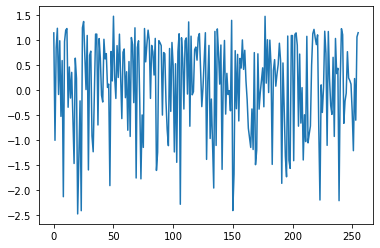

In [71]:
plt.plot(np.concatenate(instab)[:256])

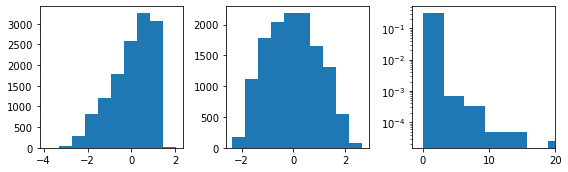

In [72]:
fig,axx=plt.subplots(1,3,figsize=(8,2.5))

ax=axx[0]
ax.hist(np.concatenate(instab).flatten())

ax=axx[1]
ax.hist(np.concatenate(subsat).flatten())

ax=axx[2]
# ax.hist(np.concatenate(conv_prc)*prc_norm_dict['normalizer'].flatten(),density=True)
ax.hist(np.concatenate(prc),density=True)

ax.set_yscale('log')
ax.set_xlim(right=20)
# ax=axx[1,0]
# ax.hist(np.concatenate(conv_nn_prc)*prc_norm.flatten())
# ax.set_yscale('log')

# ax=axx[1,1]
# ax.hist(np.concatenate(imerg_prc_tm1)*prc_norm.flatten())
# ax.set_yscale('log')

plt.tight_layout()

### Import model ###

In [73]:
import Vae_model #as VAE
import sys
importlib.reload(Vae_model)

In [75]:
LATENT_DIMS=1
INPUT_DIMS=3
NN_DIMS_ENC=12
NN_DIMS_DEC=12

model=Vae_model.CVAE_ORG_mod(LATENT_DIMS,INPUT_DIMS,
                                             NN_DIMS_ENC,NN_DIMS_DEC).to(device)
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-4,
                            weight_decay=1e-3)

### Test

In [76]:
from operator import mul
from functools import reduce # python3 compatibility

network_size=0
for params in model.parameters():
    network_size+=reduce(mul, params.size(), 1)
print('total number of parameters: {:d}'.format(network_size))

total number of parameters: 365


In [77]:
for i_batch, sample_batched in enumerate(custom_dataloader):
    
    print(sample_batched.keys())
    
    data=torch.stack((sample_batched['instab'],
                      sample_batched['subsat'],
                      sample_batched['prc']),dim=1).unsqueeze(2)
    
    optimizer.zero_grad()
    outputs=model(data)
    kl_loss, binary_loss, gamma_loss, gaussian_loss, gamma_nll_1\
    , gamma_nll_2, gamma_nll_3, gamma_nll_4  =model.vae_loss(outputs,0)

    syn_size=1_000_000
    z=torch.normal(mean=0.,std=1.,
                                size=(syn_size,LATENT_DIMS))
    
    input_tensor=torch.cat((torch.tensor([1.0]).unsqueeze(1),
                        torch.tensor([-1]).unsqueeze(1)),axis=1)    
    
    VAE_models_CVAE_one_endec.print_params(z,model,input_tensor)

    break

dict_keys(['instab', 'subsat', 'prc'])
zmax: 3.00
shape: 9.76e-01, scale: 1.17e+00
mean: 1.14
variance: 1.32
rain prob.: 0.61
------------------------
zmin: -3.00
shape: 8.11e-01, scale: 2.46e+00
mean: 2.00
variance: 4.92
rain prob.: 0.30


### Train

In [78]:
ALPHA_W=0.75

In [79]:
EPOCHS = 50
wandb.finish()

In [80]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="precip-VAE",
    # track hyperparameters and run metadata
    config={
    "learning_rate": optimizer.param_groups[0]['lr'],
    "architecture": "VAE",
    "dataset": "GPM/ERA5",
    "epochs": EPOCHS,
    "batch size":BATCH_SIZE,
    "NN DIMD": NN_DIMS_DEC,
    "NN_DIME": NN_DIMS_ENC,
    "Latent DIM": LATENT_DIMS,
    "Predictor": "lrh",
    "alpha_w":ALPHA_W,
    }
)

In [ ]:
startTime1 = datetime.now()
SAVE_MODEL=True
MODEL_NAME_STR='cvae_tr2_imerg_era5_gamma_gauss_alpha_w={}'.format(ALPHA_W)

fig,axx=plt.subplots(1,1,figsize=(6,4))
ax=axx
losses={'elbo':[],'gamma':[], 
        'gauss':[],'binary':[], 'kl':[]}

set_seed()
epoch_number = 0
best_vloss = 1_000_000.

syn_size=1_000_000
z=torch.normal(mean=0.,std=1.,
                            size=(syn_size,LATENT_DIMS))

input_thermo_tensor=torch.cat((torch.tensor([1.0]).unsqueeze(1),
                    torch.tensor([-1]).unsqueeze(1)),axis=1)    


for epoch in range(EPOCHS):
    startTime2 = datetime.now()
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    mean_ELBO, mean_gamma_loss, mean_gaussian_loss, mean_KL_loss, mean_binary_loss\
    = Vae_model.train_one_epoch(epoch_number,custom_dataloader,model,
                                                optimizer,ALPHA_W)
    
    losses['elbo'].append(mean_ELBO)
    losses['gamma'].append(mean_gamma_loss)
    losses['gauss'].append(mean_gaussian_loss)
    losses['binary'].append(mean_binary_loss)
    losses['kl'].append(mean_KL_loss)
    
    # We don't need gradients on to do reporting
    model.train(False)
    
    Vae_model.print_params(z,model,input_thermo_tensor)

    ax.scatter(epoch,mean_ELBO,color='black')
    ax.scatter(epoch,mean_gamma_loss,color='red')
    ax.scatter(epoch,mean_KL_loss,color='blue')
    ax.scatter(epoch,mean_binary_loss,color='orange')
    
    epoch_number += 1
    print("Time for epoch: {:.2f} minutes".format((datetime.now() - startTime2).total_seconds()/60))
        
    wandb.log({"ELBO": mean_ELBO, "gamma loss": mean_gamma_loss,
               "gaussian loss":mean_gaussian_loss,
              "binary loss": mean_binary_loss, "KL loss": mean_KL_loss})

    if SAVE_MODEL:
        dir_name='/home/fiaz/ML/vae/models/'

        model_name_prev=MODEL_NAME_STR+'_{}_epochs.pth'.format(epoch_number-1)
        model_name=MODEL_NAME_STR+'_{}_epochs.pth'.format(epoch_number)

        if epoch_number>1:
            os.remove(dir_name+model_name_prev)
        torch.save(model.state_dict(), dir_name+model_name)
        print('Model saved as {}'.format(dir_name+model_name))
        
print("Total time: {:.2f} minutes".format((datetime.now() - startTime1).total_seconds()/60))

wandb.finish()

Random seed set as 0
EPOCH 1:
batch 5000
max gradient:
log alpha: 2.35e-01
log mu: 8.05e-01
zmax: 3.00
shape: 5.12e-01, scale: 3.39e+00
mean: 1.74
variance: 5.89
rain prob.: 0.49
------------------------
zmin: -3.00
shape: 1.67e-01, scale: 3.55e-01
mean: 0.06
variance: 0.02
rain prob.: 0.18
gamma nll:
0.30494827 -4.3904576 1.1332061 -0.07822976 -3.0305328
-3.0305328
gaussian nll:
0.748247
------------------------------
batch 10000
max gradient:
log alpha: 8.78e-02
log mu: 5.27e-01
zmax: 3.00
shape: 3.02e+00, scale: 1.01e+00
mean: 3.06
variance: 3.09
rain prob.: 0.92
------------------------
zmin: -3.00
shape: 2.07e-01, scale: 2.36e-01
mean: 0.05
variance: 0.01
rain prob.: 0.21
gamma nll:
0.60026187 -2.5461566 0.9115058 -0.45293823 -1.4873271
-1.4873275
gaussian nll:
0.06370945
------------------------------
batch 15000
max gradient:
log alpha: 7.77e-02
log mu: 1.65e-01
zmax: 3.00
shape: 9.83e+00, scale: 3.16e-01
mean: 3.10
variance: 0.98
rain prob.: 0.99
------------------------
zmin: 

## Small scale parameters suggest small tails. 

### Diagnose

In [ ]:
# dst='/home/fiaz/ML/vae/models/cvae_gamma_conv_rain_singleED_50_epochs.pth'
# dst='/home/fiaz/ML/vae/models/cvae_gamma_conv_rain_singleED_NN=4_LD=1_48_epochs.pth'
# dst='/home/fiaz/ML/vae/models/cvae_gamma_conv_rain_singleED_NN=4_LD=2_7_epochs.pth'
# model.load_state_dict(torch.load(dst))
Vae_model.print_params(z,model,torch.tensor([0.8]))



In [ ]:
pcp_bins=2**(np.arange(-2.,8.125,0.125))
pcp_bins=np.insert(pcp_bins,0,1e-3)
pcp_bin_center=(pcp_bins[1:]+pcp_bins[:-1])*0.5
dx=np.diff(pcp_bins)

In [ ]:
import matplotlib
colors_norm1 = matplotlib.colors.Normalize(vmin=0, vmax=1.)
cmap = plt.get_cmap('YlOrRd')
col = matplotlib.cm.ScalarMappable(norm=colors_norm1, cmap=cmap)

colors_norm = matplotlib.colors.Normalize(vmin=-3, vmax=3.)
colz = matplotlib.cm.ScalarMappable(norm=colors_norm, cmap=cmap)

In [ ]:
syn_size=1_000_00
synthetic_input=torch.normal(mean=0.,std=1.,
                            size=(syn_size,LATENT_DIMS))


fig,axx=plt.subplots(2,2,figsize=(8.,5.))

for i in np.arange(0,0.95,.05)[::4]: 
    print(i)
#     synthetic_input[:,0]=3
    synthetic_input[:]=4.

    crh_cond=torch.ones([syn_size,1])
    crh_cond[:]=i
    
    log_alpha,log_beta, prob=model.decoder(synthetic_input,crh_cond)
    m1=torch.distributions.Gamma(log_alpha.exp(),log_beta.exp())
    m2=torch.distributions.Bernoulli(prob)
    
    prc_array= (m2.sample()*m1.sample()*prc_std).numpy().squeeze()
    
    prc_hist=np.histogram(prc_array,bins=pcp_bins)[0]
    prc_hist=prc_hist/(dx*prc_hist.sum())
    
    axx[0,0].scatter(pcp_bin_center,prc_hist,color=col.to_rgba(i))
    axx[0,1].hist(prob.detach().numpy().squeeze(),color=col.to_rgba(i))
    
#     if i==.5:
#         break
    
    
for i in np.arange(-3,3.2,0.2):
    
#     synthetic_input[:,0]=i
    synthetic_input[:]=i

    crh_cond=torch.ones([syn_size,1])
    crh_cond[:]=0.8
    
    log_alpha, log_beta, prob=model.decoder(synthetic_input,crh_cond)
    m1=torch.distributions.Gamma(log_alpha.exp(),log_beta.exp())
    m2=torch.distributions.Bernoulli(prob)
    
    prc_array= (m2.sample()*m1.sample()*prc_norm).numpy().squeeze()
    
    prc_hist=np.histogram(prc_array,bins=pcp_bins)[0]
    prc_hist=prc_hist/(dx*prc_hist.sum())
    
    axx[1,0].scatter(pcp_bin_center,prc_hist,color=colz.to_rgba(i))
    axx[1,1].hist(prob.detach().numpy().squeeze(),color=colz.to_rgba(i))
    
    
axx[0,0].set_yscale('log')
axx[1,0].set_yscale('log')
axx[0,0].set_xlim(0,250)
axx[1,0].set_xlim(0,250)

for ax in axx[0]:
    ax.tick_params(which='both',labelsize=13)

for ax in axx[1]:
    ax.tick_params(which='both',labelsize=13)

# axx[0,1].set_xlabel('Shape',fontsize=13)
# axx[1,1].set_xlabel('Scale',fontsize=13)
    
plt.tight_layout()